### Implementación de YOLOv8 + SAM y capa GIS para obtener alturas

In [1]:
import torch
import torchvision
from ultralytics import YOLO
import sys
import cv2
from segment_anything import sam_model_registry, SamPredictor
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torchgeo
import rasterio

In [2]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

PyTorch version: 2.0.1+cu117
Torchvision version: 0.15.2+cu117
CUDA is available: True


In [3]:
def yolov8_detection():

    model=YOLO('/home/robotica10/yolov8/runs/segment/train3/weights/best.pt')
    image = "/home/robotica10/yolov7-segmentation/c.v2i.yolov5pytorch/train/images/3b9c485d-22-288307913390632_-22-265160142211556_-68-88090586893881_-68-85607786197419_png.rf.28f47ff5afabf72e6cd9cafee69b9e92.jpg"
    
    results = model(image, stream=True)  # generator of Results objects

    for result in results:
        boxes = result.boxes  # Boxes object for bbox outputs
    
    bbox=boxes.xyxy.tolist()[0]
    return bbox

In [4]:
image = cv2.imread("/home/robotica10/yolov7-segmentation/c.v2i.yolov5pytorch/train/images/3b9c485d-22-288307913390632_-22-265160142211556_-68-88090586893881_-68-85607786197419_png.rf.28f47ff5afabf72e6cd9cafee69b9e92.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

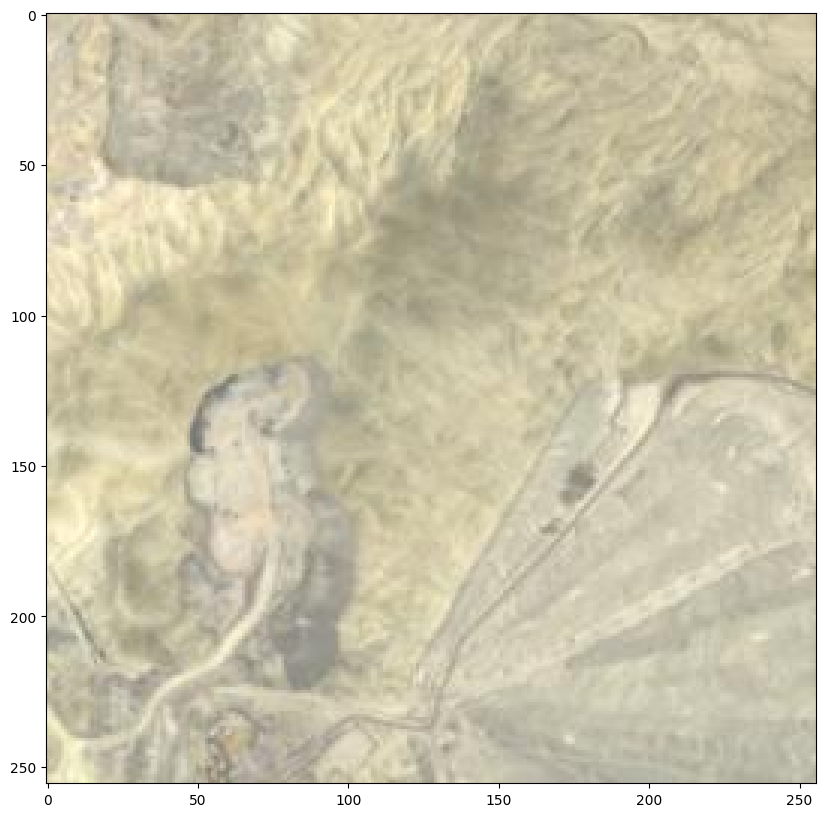

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(image)

In [6]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)
predictor.set_image(image)

In [7]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
        
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [8]:
yolov8_boxex=yolov8_detection()


image 1/1 /home/robotica10/yolov7-segmentation/c.v2i.yolov5pytorch/train/images/3b9c485d-22-288307913390632_-22-265160142211556_-68-88090586893881_-68-85607786197419_png.rf.28f47ff5afabf72e6cd9cafee69b9e92.jpg: 256x256 2 mwdss, 13.9ms
Speed: 2.8ms preprocess, 13.9ms inference, 194.9ms postprocess per image at shape (1, 3, 256, 256)


In [9]:
yolov8_boxex

[115.56317138671875, 113.45652770996094, 255.99905395507812, 255.7482452392578]

In [10]:
input_box = np.array(yolov8_boxex)
input_label = np.array([1])

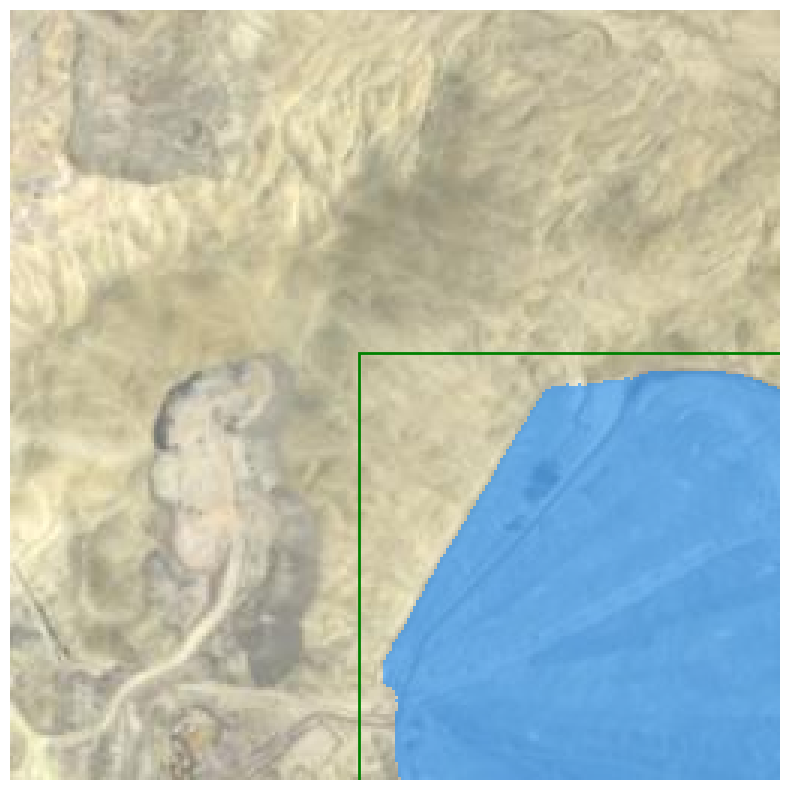

In [11]:
masks, _, _ = predictor.predict(
    point_coords=None,
    #point_labels=None,
    point_labels=input_label,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

In [12]:
def clean_filename(filename):
    # Encuentra el índice de inicio y final de las coordenadas
    start_index = 8
    end_index = filename.index("_png")

    # Extrae las coordenadas del nombre del archivo
    coordinates_str = filename[start_index:end_index]

    # Separa las coordenadas y forma la bounding box
    coordinates_list = coordinates_str.split("_")
    minx, maxx, miny, maxy = coordinates_list

    # Función para reemplazar espacios por puntos
    def replace_spaces_with_periods(coord_str):
        # Encuentra el índice del cuarto carácter (3 espacios desde el comienzo)
        indice = coord_str.find('-', 3)
        # Verifica si se encontraron al menos 3 espacios y reemplaza el siguiente carácter por un punto
        if indice != -1:
            coord_str = coord_str[:indice] + '.' + coord_str[indice+1:]
        return coord_str

    # Aplica la función a todas las coordenadas, excepto el primer guion en números negativos
    minx = replace_spaces_with_periods(minx)
    maxx = replace_spaces_with_periods(maxx)
    miny = replace_spaces_with_periods(miny)
    maxy = replace_spaces_with_periods(maxy)

    return minx, maxx, miny, maxy

# Ejemplo de uso
filename = '3b9c485d-22-288307913390632_-22-265160142211556_-68-88090586893881_-68-85607786197419_png.rf.28f47ff5afabf72e6cd9cafee69b9e92.jpg'
minx, maxx, miny, maxy = clean_filename(filename)
bounding_box = f"{minx} {maxx} {miny} {maxy}"
print(bounding_box)

-22.288307913390632 -22.265160142211556 -68.88090586893881 -68.85607786197419


In [13]:
# Tamaño de la imagen en píxeles
image_width = 256
image_height = 256

# Convertir las coordenadas a números de punto flotante
minx = float(minx)
maxx = float(maxx)
miny = float(miny)
maxy = float(maxy)

# Calcular las diferencias en latitud y longitud
lat_diff = maxx - minx
lon_diff = maxy - miny

# Crear una matriz de píxeles con coordenadas latitud y longitud
pixel_coordinates = np.zeros((image_height, image_width, 2), dtype=float)

for i in range(image_height):
    for j in range(image_width):
        # Calcular las coordenadas latitud y longitud para cada pixel
        lat = minx + (i / (image_height - 1)) * lat_diff
        lon = miny + (j / (image_width - 1)) * lon_diff
        
        # Almacenar las coordenadas en la matriz
        pixel_coordinates[i, j, 0] = lat
        pixel_coordinates[i, j, 1] = lon

# Ahora pixel_coordinates contiene las coordenadas de latitud y longitud
# correspondientes a cada píxel de la imagen.


In [14]:
# Crear una matriz para almacenar las coordenadas de latitud y longitud mapeadas
lat_lon_coordinates = np.zeros((256, 256, 2), dtype=float)

for i in range(256):
    for j in range(256):
        if masks[0, i, j]:  # Acceder a la máscara en la posición (0, i, j)
            # Invertir el orden de recorrido de las filas para mapear hacia abajo
            lat = minx + ((255 - i) / 255.0) * lat_diff
            lon = miny + (j / 255.0) * lon_diff
            lat_lon_coordinates[i, j, 0] = lat
            lat_lon_coordinates[i, j, 1] = lon

# Ahora 'lat_lon_coordinates' contiene las coordenadas de latitud y longitud mapeadas
# correspondientes a las ubicaciones 'True' en la máscara de segmentación.


In [15]:
# Imprimir un valor con mayor precisión
print(f"{lat_lon_coordinates[255, 255, 0]:.15f}, {lat_lon_coordinates[255, 255, 1]:.15f}")
print(f"{lat_lon_coordinates[255, 255, 1]:.15f}, {lat_lon_coordinates[255, 255, 0]:.15f}")


-22.288307913390632, -68.856077861974185
-68.856077861974185, -22.288307913390632


In [16]:
FILE_ELEVACION = '/media/robotica10/Datos/PROYECTO_SIG_RELAVES/Proyecto_SIG_Antofagasta/Topografia/Antogafasta_elevacion.tif'

In [17]:
lon = lat_lon_coordinates[255,255,1]
lon

-68.85607786197419

In [18]:
lat = lat_lon_coordinates[255,255,0]
lat

-22.288307913390632

Acople con GIS

In [ ]:
from osgeo import gdal
import numpy as np
from scipy.interpolate import RegularGridInterpolator

elevation_ds = gdal.Open(FILE_ELEVACION)
elevation_array = elevation_ds.ReadAsArray()

# Coordenadas originales de los datos de elevación
x = np.linspace(0, elevation_array.shape[1] * 12.5, elevation_array.shape[1])
y = np.linspace(0, elevation_array.shape[0] * 12.5, elevation_array.shape[0])

# Interpolador
interpolator = RegularGridInterpolator((y, x), elevation_array)

# Crear una lista para almacenar las elevaciones
elevaciones = []

# Iterar sobre todas las coordenadas en lat_lon_coordinates
for i in range(256):
    for j in range(256):
        lat = lat_lon_coordinates[i, j, 0]
        lon = lat_lon_coordinates[i, j, 1]
        print(f"{lat}, {lon} \n")

        
        # Verificar si las coordenadas son diferentes de 0.0
        if lat != 0.0 and lon != 0.0:
            # Ajustar las coordenadas al tamaño de píxel del DEM
            lat_adjusted = lat * (12.5 / 10.0)
            lon_adjusted = lon * (12.5 / 10.0)
            print(f"Aju: {lat_adjusted}, {lon_adjusted} \n")
            
            # Verificar si las coordenadas ajustadas están dentro de los límites del DEM
            if (0 <= lat_adjusted <= max(y)) and (0 <= lon_adjusted <= max(x)):
                # Obtener la elevación interpolando en el DEM
                elevation = interpolator((lat_adjusted, lon_adjusted))
                elevaciones.append(elevation)
            else:
                # Si las coordenadas están fuera de los límites, agregar un valor de elevación inválido
                elevaciones.append(None)  # O puedes usar otro valor para indicar que está fuera de los límites
        else:
            # Si las coordenadas son 0.0, agregar un valor de elevación inválido
            elevaciones.append(None)  # O puedes usar otro valor para indicar que es 0.0

# Ahora elevaciones contiene todas las elevaciones correspondientes a las coordenadas en lat_lon_coordinates


In [ ]:
# Suponiendo que las coordenadas en lat_lon_coordinates están en 10x10 metros
# y quieres ajustarlas a 12.5x12.5 metros

# Factor de ajuste para latitud y longitud
lat_adjustment = 12.5 / 10.0
lon_adjustment = 12.5 / 10.0

# Ajustar las coordenadas en lat_lon_coordinates
lat_lon_coordinates[:, :, 0] *= lat_adjustment
lat_lon_coordinates[:, :, 1] *= lon_adjustment


In [19]:
# Abrir el archivo rasterio una vez fuera del bucle
with rasterio.open(FILE_ELEVACION) as src:
    elev_data = src.read(1)

elevaciones = []

# Iterar sobre todas las coordenadas en lat_lon_coordinates
for i in range(256):
    for j in range(256):
        lat = lat_lon_coordinates[i, j, 0]
        lon = lat_lon_coordinates[i, j, 1]
        if lat == 0.0 and lon == 0.0:
            elevaciones.append(0)
        if lat != 0.0 and lon != 0.0:
            xy = src.index(lon, lat)
            elev = elev_data[xy]
            elevaciones.append(elev)
            print(f"{lat}, {lon}, {elev}")

# Ahora puedes seguir utilizando 'elevaciones' como lo necesites


-22.27605321100171, -68.86026454550155, 2927.0
-22.27605321100171, -68.86016718076836, 2923.0
-22.27605321100171, -68.86006981603516, 2923.0
-22.27605321100171, -68.85997245130197, 2919.0
-22.27605321100171, -68.85987508656878, 2915.0
-22.27605321100171, -68.85977772183558, 2908.0
-22.27605321100171, -68.85968035710239, 2906.0
-22.27605321100171, -68.8595829923692, 2906.0
-22.27605321100171, -68.85948562763599, 2904.0
-22.27605321100171, -68.8593882629028, 2901.0
-22.27605321100171, -68.8592908981696, 2901.0
-22.27605321100171, -68.85919353343641, 2899.0
-22.27605321100171, -68.85909616870322, 2897.0
-22.27605321100171, -68.85899880397002, 2896.0
-22.27605321100171, -68.85890143923683, 2895.0
-22.27605321100171, -68.85880407450364, 2892.0
-22.27605321100171, -68.85870670977044, 2889.0
-22.27605321100171, -68.85860934503725, 2889.0
-22.27605321100171, -68.85851198030404, 2889.0
-22.27605321100171, -68.85841461557085, 2887.0
-22.27605321100171, -68.85831725083766, 2884.0
-22.276053211001

In [20]:
elev_reshaped = np.reshape(elevaciones, (256, 256))

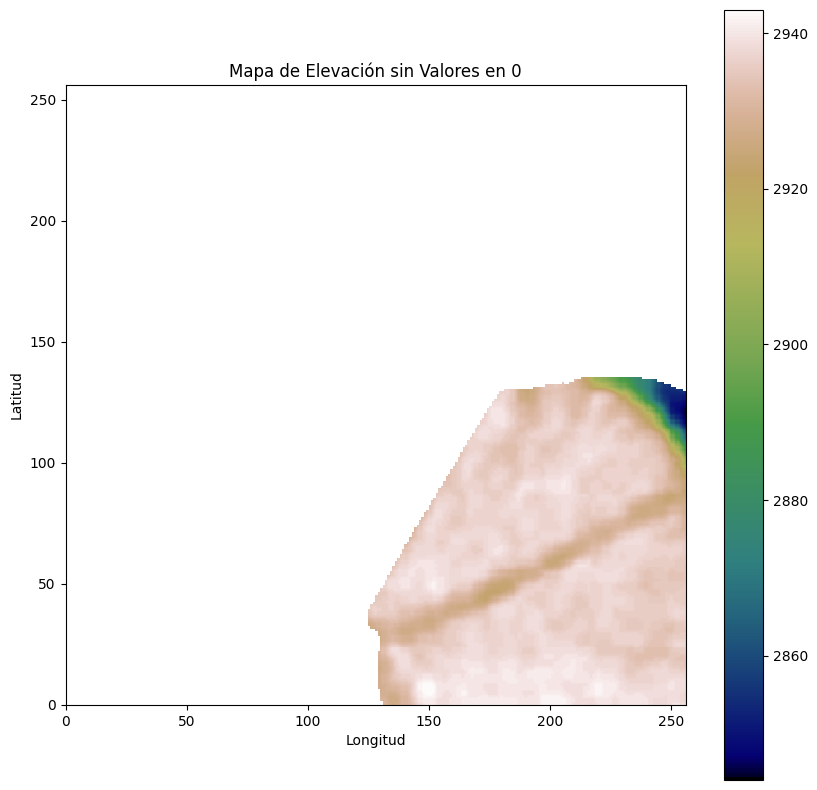

In [21]:

# Supongamos que tienes un ndarray llamado 'elevation_data' de tamaño 256x256 con tus datos de elevación

# Crear una máscara donde los valores iguales a 0 se convierten en NaN
masked_elevation_data = np.where(elev_reshaped == 0, np.nan, elev_reshaped)

# Crear una figura y un eje para el mapa de calor
fig, ax = plt.subplots(figsize=(10, 10))

# Visualizar el mapa de calor sin los valores iguales a 0
heatmap = ax.imshow(masked_elevation_data, cmap='gist_earth', extent=[0, 256, 0, 256], vmin=np.nanmin(masked_elevation_data), vmax=np.nanmax(masked_elevation_data))

# Agregar una barra de color para la escala de elevación
cbar = plt.colorbar(heatmap)

# Establecer etiquetas de ejes y título
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_title('Mapa de Elevación sin Valores en 0')

# Mostrar el mapa de calor
plt.show()


### Visualizacion de mascaras predichas con YOLOv8

In [ ]:
def random_label_path(label_folder):
    # Lista de archivos .txt en la carpeta de etiquetas
    labels = [f for f in os.listdir(label_folder) if f.endswith('.txt')]
    
    # Seleccionar un archivo de etiqueta al azar
    random_label_name = random.choice(labels)
    label_path = os.path.join(label_folder, random_label_name)

    return label_path

def show_image_and_mask(image_path, label_path):
    # Cargar imagen
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Leer y aplicar máscara
    with open(label_path, 'r') as file:
        mask_coords = [float(coord) for coord in file.read().split()[1:]]  # Ignorar el primer número (clase)
        mask = coords_to_mask(mask_coords, image_path)

    # Mostrar imagen y máscara
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Imagen')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Máscara')
    plt.axis('off')

    plt.show()

def coords_to_mask(coords, image_path):
    image = cv2.imread(image_path)
    height, width, _ = image.shape
    mask = np.zeros((height, width), dtype=np.uint8)

    # Convertir coordenadas normalizadas en coordenadas de píxeles reales
    points = [(int(x * width), int(y * height)) for x, y in zip(coords[::2], coords[1::2])]
    points = np.array(points, dtype=np.int32).reshape((-1, 1, 2))

    # Dibujar la máscara
    cv2.fillPoly(mask, [points], 255)  # 255 para la máscara blanca

    return mask

def find_corresponding_image(label_path, image_folder):
    # Obtener el nombre del archivo de imagen correspondiente
    image_filename = os.path.basename(label_path).replace('.txt', '.png')
    image_path = os.path.join(image_folder, image_filename)

    return image_path

In [ ]:
# Rutas a las carpetas de imágenes y etiquetas
image_folder = '/home/robotica10/yolov8/runs/segment/predict'
label_folder = os.path.join(image_folder, 'labels')

# Obtener un archivo de etiqueta al azar y la imagen correspondiente
label_path = random_label_path(label_folder)
image_path = find_corresponding_image(label_path, image_folder)

# Mostrar la imagen y su máscara
show_image_and_mask(image_path, label_path)
